In [31]:
import pandas as pd
import numpy as np
import warnings
import pmdarima as pm
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from common.preprocessor import load_data, mape
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
# %matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [32]:
data = pd.read_csv('Modified Data.csv',parse_dates=True, index_col=[0])

In [33]:
data.head()

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


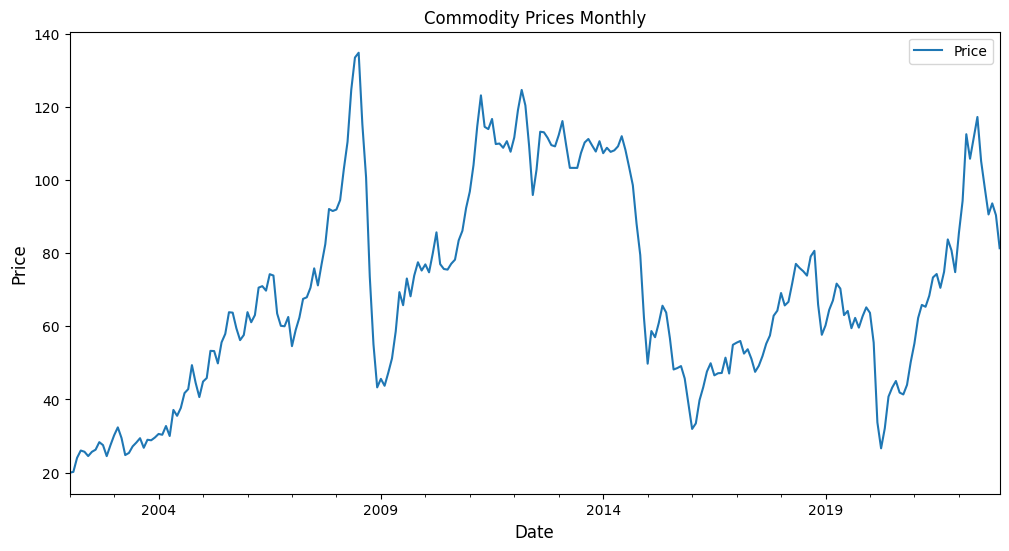

In [34]:
data.plot(y='Price', title='Commodity Prices Monthly', figsize=(12, 6))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.show()

In [35]:
#create training and testing datasets
train, test = train_test_split(data, test_size=0.2, shuffle=False)

In [36]:
train.shape, test.shape

((201, 1), (51, 1))

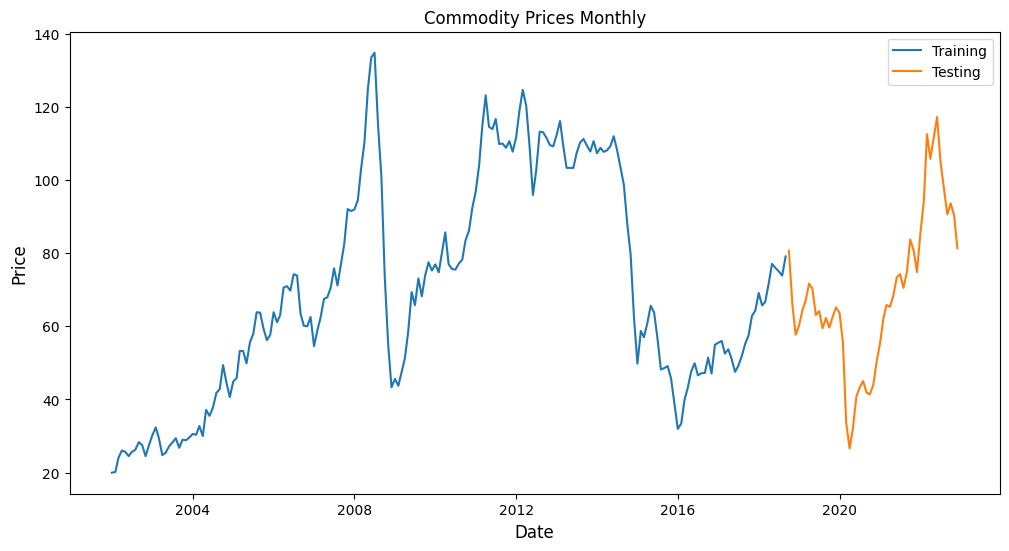

In [37]:
# visualize the training and testing datasets
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training')
plt.plot(test, label='Testing')
plt.title('Commodity Prices Monthly')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.show()

In [38]:
# make a copy of the original training and testing datasets
scaled_train = train.copy()
scaled_test = test.copy()

In [39]:
# prepare data for training
scaler = MinMaxScaler()
scaled_train['Price'] = scaler.fit_transform(scaled_train[['Price']])
scaled_train.head()

,Price
2002-01-01,0.00
2002-02-01,0.00
2002-03-01,0.04
2002-04-01,0.05
2002-05-01,0.05


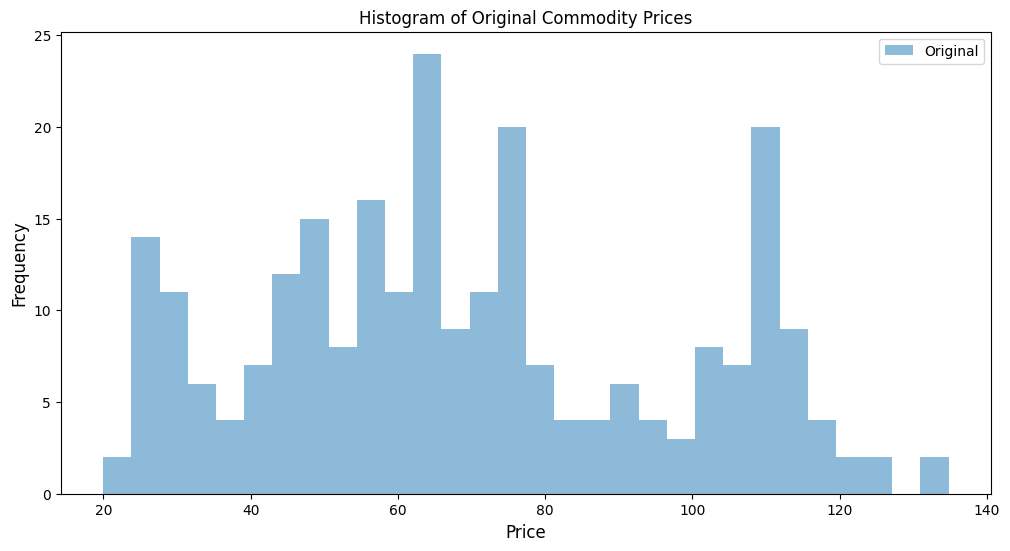

In [40]:
# Plot original data
plt.figure(figsize=(12, 6))
plt.hist(data['Price'], bins=30, alpha=0.5, label='Original')
plt.title('Histogram of Original Commodity Prices')
plt.xlabel('Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

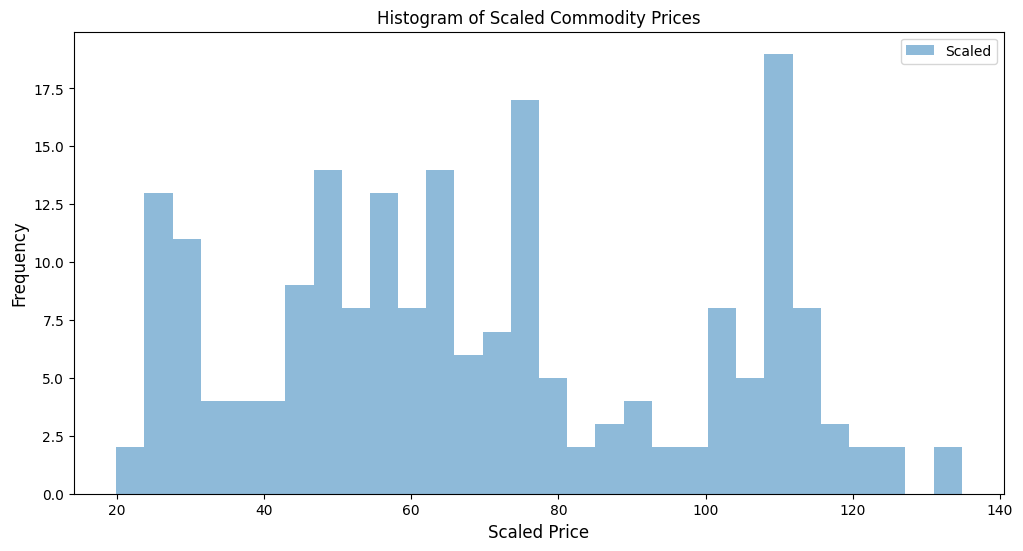

In [41]:
# Plot scaled data
plt.figure(figsize=(12, 6))
plt.hist(train['Price'], bins=30, alpha=0.5, label='Scaled')
plt.title('Histogram of Scaled Commodity Prices')
plt.xlabel('Scaled Price', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

In [42]:
# scale test data
scaled_test['Price'] = scaler.transform(scaled_test[['Price']])
scaled_test.head()

,Price
2018-10-01,0.53
2018-11-01,0.40
2018-12-01,0.33
2019-01-01,0.35
2019-02-01,0.39


In [43]:
#check to see if data is stationary
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'No. of lags used: {result[2]}')
    print(f'No. of observations used: {result[3]}')
    print('Critical Values:')
    for k, v in result[4].items():
        print(f'   {k}: {v}')
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
adf_test(scaled_train['Price'])

ADF Statistic: -2.4610076050408614
p-value: 0.1252520709317187
No. of lags used: 1
No. of observations used: 199
Critical Values:
   1%: -3.4636447617687436
   5%: -2.8761761179270766
   10%: -2.57457158581854
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [44]:
adf_test(scaled_test['Price'])

ADF Statistic: -1.5490837254384264
p-value: 0.5091058548155425
No. of lags used: 1
No. of observations used: 49
Critical Values:
   1%: -3.5714715250448363
   5%: -2.922629480573571
   10%: -2.5993358475635153
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [45]:
# Assuming `data` is your time series data
n_diffs = pm.arima.ndiffs(scaled_train['Price'], test='adf')  # 'adf' for Augmented Dickey-Fuller test

print(f"Number of differences required: {n_diffs}")

Number of differences required: 1


In [46]:
# Assuming `data` is your time series data
n_diffs = pm.arima.ndiffs(scaled_test['Price'], test='adf')  # 'adf' for Augmented Dickey-Fuller test

print(f"Number of differences required: {n_diffs}")

Number of differences required: 2


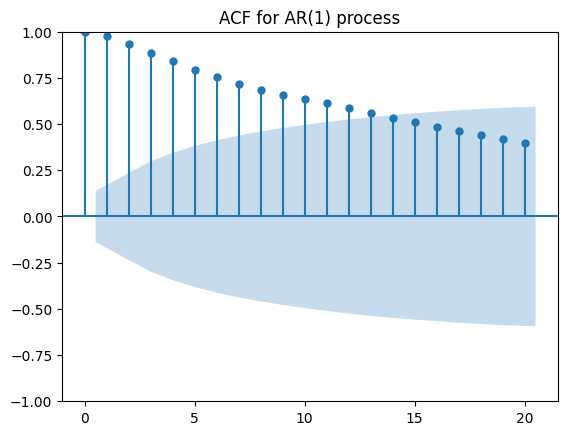

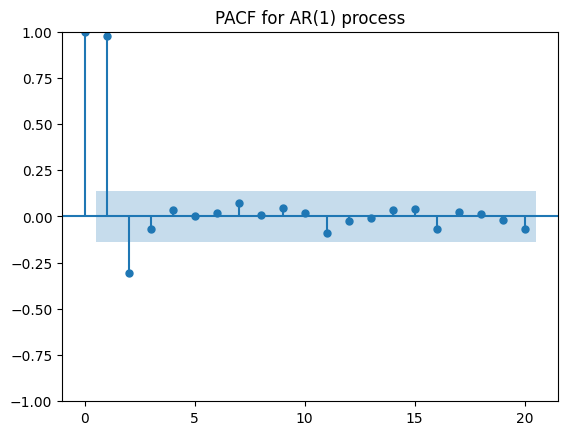

In [47]:
# acf and pacf plots for ar(1) and ma(1) processes
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# AR(1) process
plot_acf(scaled_train['Price'], lags=20, title='ACF for AR(1) process')
plt.show()
plot_pacf(scaled_train['Price'], lags=20, title='PACF for AR(1) process')
plt.show()


In [48]:
# use auto arima to find the best parameters for training
model = auto_arima(scaled_train['Price'], start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1,max_d=2, D=1,max_D=2, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-468.903, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-527.661, Time=0.43 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.46 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-501.630, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-552.531, Time=0.99 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.38 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.33 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-520.836, Time=0.85 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-550.995, Time=1.26 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-550.837, Time=2.37 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-544.683, Time=1.21 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=-548.736, Time=3.53 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=-550.543, Time=2.54 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]  

In [61]:
# First difference
differenced_train= scaled_train.diff().dropna()
differenced_train.head()

,Price
2002-02-01,0.00
2002-03-01,0.03
2002-04-01,0.02
2002-05-01,-0.00
2002-06-01,-0.01


In [50]:
# Seasonal difference
# Assuming the seasonality is 12 (e.g., for monthly data), adjust as necessary
train_seasonal_diff = train_diff.diff(12).dropna()
train_seasonal_diff.head()

,Price
2003-02-01,0.02
2003-03-01,-0.06
2003-04-01,-0.06
2003-05-01,0.01
2003-06-01,0.03


In [51]:
# Do the same for the test set
test_diff = scaled_test.diff().dropna()
test_diff.head()

,Price
2018-11-01,-0.13
2018-12-01,-0.07
2019-01-01,0.02
2019-02-01,0.04
2019-03-01,0.02


In [52]:
test_seasonal_diff = test_diff.diff(12).dropna()
test_seasonal_diff.head()

,Price
2019-11-01,0.15
2019-12-01,0.09
2020-01-01,-0.04
2020-02-01,-0.11
2020-03-01,-0.21


In [53]:
# use auto arima to find the best parameters
model = auto_arima(train_seasonal_diff, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1,max_d=2, D=1,max_D=2, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
model.fit(train_seasonal_diff)

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.01 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-227.514, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-307.509, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.82 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-249.867, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-349.125, Time=0.87 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.00 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-326.501, Time=0.60 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-349.846, Time=1.26 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-308.588, Time=0.57 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.97 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.89 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-357.965, Time=1.42 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=-312.959, Time=0.75 sec
 ARIMA(3,1,0)(2,1,1)[12] 

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [54]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_seasonal_diff, order=(3,1,0), seasonal_order=(2,1,0,12), freq="MS")
model_fit = model.fit(disp=0) # disp=0 to suppress convergence output to avoid clutter in the notebook

In [55]:
# Make predictions on the differenced seasonal test dataset.
predictions = model_fit.predict(start=test_seasonal_diff.index[0], end=test_seasonal_diff.index[-1])

# Reverse the seasonal differencing.
predictions_diff = pd.Series(predictions, index=test_seasonal_diff.index)
predictions_seasonal = pd.Series(test_diff.iloc[0], index=test_diff.index)
predictions_seasonal = predictions_seasonal.add(predictions_diff, fill_value=0).fillna(0)

# Reverse the first differencing.
predictions = pd.Series(test.iloc[0], index=test.index)
predictions = predictions.add(predictions_seasonal.cumsum(), fill_value=0).fillna(0)

# Reverse the scaling.
predictions = scaler.inverse_transform(predictions.values.reshape(-1, 1))

# Convert the predictions to a Series.
predictions = pd.Series(predictions.flatten(), index=test.index)

In [56]:
test.head()

,Price
2018-10-01,80.63
2018-11-01,65.96
2018-12-01,57.67
2019-01-01,60.23
2019-02-01,64.50


In [57]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Calculate the MSE
mse = mean_squared_error(test, predictions)
print(f'MSE: {mse}')


MSE: 4748.605295060496


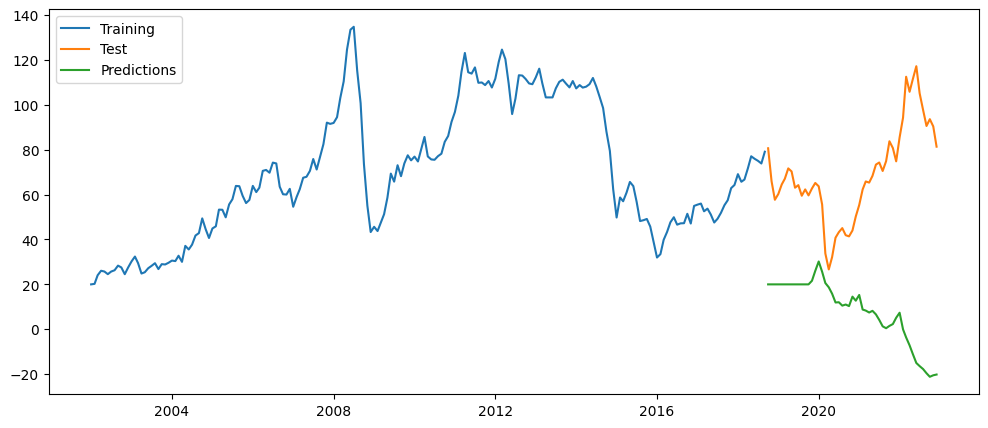

In [58]:
# Plot the results
plt.figure(figsize=(12,5))
plt.plot(train, label='Training')
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

In [59]:
# show a table of the predicted values 
results = pd.DataFrame({'Actual': test['Price'], 'Predicted': predictions})
results

,Actual,Predicted
2018-10-01,80.63,19.96
2018-11-01,65.96,19.96
2018-12-01,57.67,19.96
2019-01-01,60.23,19.96
2019-02-01,64.50,19.96
2019-03-01,67.05,19.96
2019-04-01,71.66,19.96
2019-05-01,70.30,19.96
2019-06-01,63.05,19.96
2019-07-01,64.19,19.96


In [60]:
%%time
print('Thanks for being with us')

Thanks for being with us
CPU times: total: 0 ns
Wall time: 1.05 ms
